In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

from scipy.fftpack import fft,fftshift,ifft
import tqdm

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals = supercluster_signals.T
supercluster_signals.shape

(30456, 501)

In [3]:
### ADDING THIS 20230421
#supercluster_signals /= np.std(supercluster_signals,axis=1)[:,np.newaxis]

In [4]:
supercluster_signals_fly = np.reshape(supercluster_signals,([9,3384,501]))

In [5]:
### for a given supercluster, i need to know the original median z-depth for each fly ###

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:24<00:00,  2.68s/it]


In [6]:
### maybe the easiest way to do this is have a single behavior trace at original res (50Hz)
### I think it will be safest to use the raw neural data (not interpolated) and assign to bins

In [7]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [8]:
fictrac = []
fictrac_fwd = []
fictrac_any = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)
    
    #also get fwd
    sphere_radius = 4.5e-3 # in m
    behavior = 'dRotLabY'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * sphere_radius * fps * 1000 # now in mm/sec
    fictrac_fwd.append(fictrac_smoothed)
    
    # also get "any" ball movement
    any_rot = np.sqrt(np.asarray(fictrac_raw['dRotLabZ'])**2 +
    np.asarray(fictrac_raw['dRotLabY'])**2 +
    np.asarray(fictrac_raw['dRotLabX'])**2)
    any_rot_smoothed = scipy.signal.savgol_filter(any_rot,25,3)
    fictrac_any.append(any_rot_smoothed)

In [9]:
fictrac_timestamps = np.arange(0,30*60*1000,20)
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [10]:
final_flies = [0,4,6,7,8]
final_flies = [0,1,2,3,4,5,6,7,8]


In [11]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9):
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [12]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################
### change window to 60 instead of 40 for seeing full 30sec

neural_traces_L = {}
neural_traces_R = {}

for cluster in tqdm.tqdm(range(500)):
    
    neural_traces_L[cluster] = []
    neural_traces_R[cluster] = []
    

    for fly in final_flies:#range(len(peaks_all_fly)):
    
        z = original_z_depth[fly,cluster]
        neural_timestamps_cluster = neural_timestamps[:,z]
        
        for beh in ['L', 'R']:
            
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            
            for peak in peaks_in_ms:
                
                #this will give the index of the first neural data after the peak
                # 40 index will be the bin from 0 to 532ms after the peak
                middle = np.searchsorted(neural_timestamps_cluster,peak)
                if beh == 'L':
                    neural_traces_L[cluster].append(supercluster_signals_fly[fly,middle-60:middle+60,cluster]) #60
                elif beh == 'R':
                    neural_traces_R[cluster].append(supercluster_signals_fly[fly,middle-60:middle+60,cluster])
                    
    neural_traces_L[cluster] = np.asarray(neural_traces_L[cluster])
    neural_traces_R[cluster] = np.asarray(neural_traces_R[cluster])

100%|██████████| 500/500 [00:08<00:00, 57.86it/s]


In [12]:
xs = np.arange(0,532*60,532)+(532/2) #change to 60 if changed above
low_res_xs = np.concatenate((xs[::-1]*-1, xs))
low_res_xs[0]

-31654.0

In [155]:
low_res_xs[33], low_res_xs[44]

(-14098.0, -8246.0)

In [157]:
low_res_xs[75], low_res_xs[88]

(8246.0, 15162.0)

In [144]:
neural_traces_L[77].shape

(1362, 120)

In [67]:
rs_L = []
rs_R = []
cluster = 203
for i in range(120):
    r,p = scipy.stats.pearsonr(neural_traces_L[cluster][:,i],neural_traces_L[cluster+250][:,i])
    rs_L.append(r)
    
    r,p = scipy.stats.pearsonr(neural_traces_R[cluster][:,i],neural_traces_R[cluster+250][:,i])
    rs_R.append(r)

In [164]:
rs_L = []
rs_R = []
cluster = 186
for i in range(1362):
    r,p = scipy.stats.pearsonr(neural_traces_L[cluster][i,33:44],neural_traces_L[cluster+250][i,33:44])
    rs_L.append(r)
    
    r,p = scipy.stats.pearsonr(neural_traces_L[cluster][i,75:88],neural_traces_L[cluster+250][i,75:88])
    rs_R.append(r)
    
    #r,p = scipy.stats.pearsonr(neural_traces_R[cluster][:,i],neural_traces_R[cluster+250][:,i])
    #rs_R.append(r)

In [165]:
np.mean(rs_L), np.mean(rs_R)

(0.17147402126965183, 0.1510341808169052)

Text(0.5, 0.98, '186')

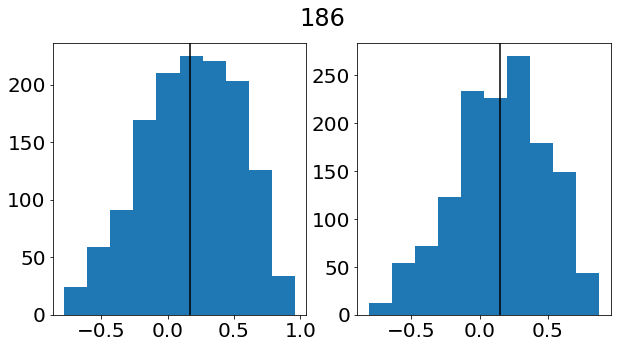

In [166]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(rs_L)
plt.axvline(np.mean(rs_L),color='k')
plt.subplot(122)
plt.hist(rs_R)
plt.axvline(np.mean(rs_R),color='k')
plt.suptitle(cluster)

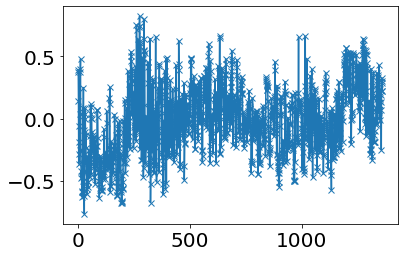

In [127]:
plt.plot(rs_L,marker='x')
#plt.plot(rs_R,marker='x')

In [111]:
cluster = 77
L = np.mean(supercluster_signals[:,[77,185,186]],axis=1)
R = np.mean(supercluster_signals[:,[77+250,185+250,186+250]],axis=1)
r,p = scipy.stats.pearsonr(L, R)
r

0.034729890170498684

In [117]:
cluster = 186
r,p = scipy.stats.pearsonr(supercluster_signals[:,cluster], supercluster_signals[:,cluster+250])
r

0.17577731529878318

In [105]:
temp = []
for cluster in range(250):
    clusters = [cluster]
    lt_lb = np.zeros(neural_traces_L[77].shape)
    for cluster in clusters:
        lt_lb+=neural_traces_L[cluster]
    lt_lb /= len(clusters)

    rt_lb = np.zeros(neural_traces_R[77].shape)
    for cluster in clusters:
        rt_lb+=neural_traces_R[cluster]
    rt_lb /= len(clusters)

    clusters = [i+250 for i in clusters]

    lt_rb = np.zeros(neural_traces_L[77].shape)
    for cluster in clusters:
        lt_rb+=neural_traces_L[cluster]
    lt_rb /= len(clusters)

    rt_rb = np.zeros(neural_traces_R[77].shape)
    for cluster in clusters:
        rt_rb+=neural_traces_R[cluster]
    rt_rb /= len(clusters)

    # low res neural
    neural_L = lt_lb-lt_rb
    neural_R = rt_lb-rt_rb

    # re-zscore for avg trace plot
    neural_L/=np.std(neural_L)
    neural_R/=np.std(neural_R)

    neural_low_res = {'L': neural_L, 'R': neural_R}

    beh = 'R'
    num_bout = 27
    out = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],:],axis=0)
    temp.append(np.mean(out[:50]))

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [70]:
num_bout

10000

In [118]:
temp[77]

0.09003447284201634

In [107]:
np.argsort(temp)[::-1]

array([208,  79,  87,  15,  53,  31,  45, 107, 222, 221,  77,   3, 225,
       169,  20,  93, 197, 120, 112, 240,  10,  68, 185, 206,  80,  39,
         0, 249,  57, 215, 224, 190, 163, 184,  91, 186, 196,  29, 192,
       216, 181, 227,  22,  43, 176,  73, 121,  76,  60, 114, 160, 217,
       171,   8, 191,  84, 142,  69, 105, 147, 174,  42, 231, 132, 127,
       156,  44,  58, 193,  71, 106,  59,  92, 166, 167, 123,  35, 125,
       139, 161,  72,  75,  37, 155,  30, 164,  90, 162,  99, 143, 109,
       134, 154, 138,  34, 233, 168, 136, 152,  49, 228, 130,  26, 116,
       117,  25,  24, 239,  32,   7, 146,  16, 203, 212, 241, 199,  82,
        98, 229, 201, 209, 180,  61, 157,  88, 151,  54,  38, 220, 111,
       128, 202, 188,  94,  28,  96, 189, 133, 235,  33, 126, 230, 207,
        21, 103, 242, 238, 145, 246, 165,  65, 150,   6,  27,  12, 182,
       148,  83,  14,  50, 219,  56,  70, 178,  13, 210, 113, 204, 179,
       170,   1, 159, 218,  23,   4, 198, 118,  46, 194,  78, 15

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


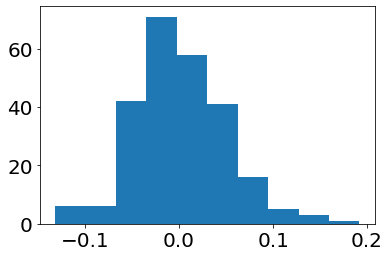

In [109]:
plt.hist(temp);

In [120]:
np.sort([222, 208, 221, 79,  87,  15,  53,  31,  45, 107])[::-1]

array([222, 221, 208, 107,  87,  79,  53,  45,  31,  15])

In [39]:
clusters = [27,243,11,12] #LH
#clusters = [57,77,185]#186 #IPS
#clusters = [106] 

#clusters = [57,77,185,186]
#clusters = list(range(250))
#del clusters[186]; del clusters[185]; del clusters[77]; del clusters[57]


#to_del = [222,221,208,186,185,107,87,79,77,57,53,45,31,15]
#for cluster in to_del:
#    del clusters[cluster]

#clusters = [79]

#clusters = [25,27]
#clusters = [198,  27,  21,  39, 116,  52, 216, 147, 178, 115,  11, 239,   7,
#         77, 185, 134,  34, 103, 227, 151, 224, 165, 245,   9,  26, 158,
#        142, 223,  12, 113,  71, 129, 186,  85,  47,  90, 160, 173,   5,
#         62, 204, 203, 104, 219, 242, 180,  81,  30, 143,  41, 225, 163,
#        246, 175,  89, 187,  25, 230, 149,  16, 199,  96, 150, 249, 201,
#         17,   8, 229, 194, 212,  86, 118, 111,  88, 106, 152, 237, 213,
#        122,  18, 123,   1,  43, 176,  57, 138, 154,  66, 182, 183,  60,
#        112,  14, 221, 161,  93,  35, 140, 195,  10]
#clusters = list(range(250))
#clusters = [185,  77, 186, 203,  80,  14, 142,  57, 175, 227, 179,  45, 134]
#clusters = [203]

lt_lb = np.zeros(neural_traces_L[77].shape)
for cluster in clusters:
    lt_lb+=neural_traces_L[cluster]
lt_lb /= len(clusters)

rt_lb = np.zeros(neural_traces_R[77].shape)
for cluster in clusters:
    rt_lb+=neural_traces_R[cluster]
rt_lb /= len(clusters)

clusters = [i+250 for i in clusters]

lt_rb = np.zeros(neural_traces_L[77].shape)
for cluster in clusters:
    lt_rb+=neural_traces_L[cluster]
lt_rb /= len(clusters)

rt_rb = np.zeros(neural_traces_R[77].shape)
for cluster in clusters:
    rt_rb+=neural_traces_R[cluster]
rt_rb /= len(clusters)

In [112]:
rt_rb.shape

(2424, 120)

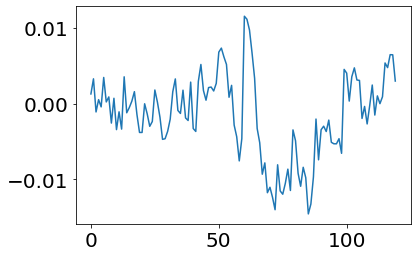

In [113]:
plt.plot(np.mean(lt_lb-lt_rb,axis=0))

(-0.07, 0.07)

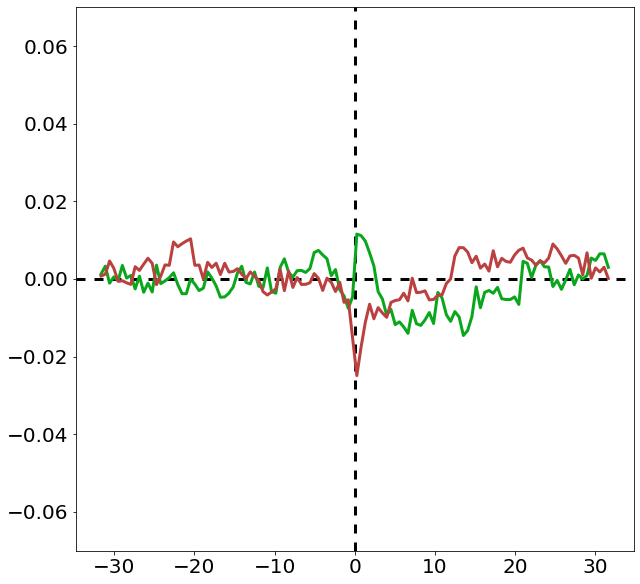

In [116]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.plot(low_res_xs/1000,np.mean(lt_lb-lt_rb,axis=0),color='#0AA71D',lw=3)
plt.plot(low_res_xs/1000,np.mean(rt_lb-rt_rb,axis=0),color='#BB4141',lw=3)
# plt.axvline(xs[13]/1000,color='k')
# plt.axvline(xs[25]/1000,color='k')
#plt.title(cluster)
#plt.xlabel('Time, sec')
#plt.legend()
plt.ylim(-.07,.07)

# alt_windows = [(12,20),(27,35),(44,52),(59,67)]
# large_windows = [(0,11),(12,23),(24,35),(39,40),(44,55),(56,67),(68,79)]
# for window in alt_windows:
#     plt.axvspan(xs[window[0]]/1000, xs[window[1]]/1000, alpha=0.5, color='grey')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# #plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [14]:
window = 1500
beh_traces_L = []
beh_traces_R = []
beh_traces_L_F = []
beh_traces_R_F = []
beh_traces_L_A = []
beh_traces_R_A = []

for fly in final_flies:
    
    beh_traces_L_fly = []
    beh_traces_R_fly = []
    beh_traces_L_F_fly = []
    beh_traces_R_F_fly = []
    beh_traces_L_A_fly = []
    beh_traces_R_A_fly = []
    
    for beh in ['L', 'R']:
        peaks_in_ms = peaks_all_fly[fly][beh]
        for peak in peaks_in_ms:
            bout = fictrac[fly][peak-window:peak+window]
            fwd_bout = fictrac_fwd[fly][peak-window:peak+window]
            any_bout = fictrac_any[fly][peak-window:peak+window]
            if beh == 'L':
                beh_traces_L_fly.append(bout)
                beh_traces_L_F_fly.append(fwd_bout)
                beh_traces_L_A_fly.append(any_bout)
            elif beh == 'R':
                beh_traces_R_fly.append(bout)
                beh_traces_R_F_fly.append(fwd_bout)
                beh_traces_R_A_fly.append(any_bout)
                
    beh_traces_L.append(np.asarray(beh_traces_L_fly))
    beh_traces_R.append(np.asarray(beh_traces_R_fly))
    beh_traces_L_F.append(np.asarray(beh_traces_L_F_fly))
    beh_traces_R_F.append(np.asarray(beh_traces_R_F_fly))
    beh_traces_L_A.append(np.asarray(beh_traces_L_A_fly))
    beh_traces_R_A.append(np.asarray(beh_traces_R_A_fly))
    
beh_traces_L_stacked = np.empty((0,window*2))
beh_traces_R_stacked = np.empty((0,window*2))
beh_traces_L_F_stacked = np.empty((0,window*2))
beh_traces_R_F_stacked = np.empty((0,window*2))
beh_traces_L_A_stacked = np.empty((0,window*2))
beh_traces_R_A_stacked = np.empty((0,window*2))
for fly in range(len(final_flies)):
    beh_traces_L_stacked = np.concatenate((beh_traces_L_stacked, beh_traces_L[fly]))
    beh_traces_R_stacked = np.concatenate((beh_traces_R_stacked, beh_traces_R[fly]))
    beh_traces_L_F_stacked = np.concatenate((beh_traces_L_F_stacked, beh_traces_L_F[fly]))
    beh_traces_R_F_stacked = np.concatenate((beh_traces_R_F_stacked, beh_traces_R_F[fly]))
    beh_traces_L_A_stacked = np.concatenate((beh_traces_L_A_stacked, beh_traces_L_A[fly]))
    beh_traces_R_A_stacked = np.concatenate((beh_traces_R_A_stacked, beh_traces_R_A[fly]))

In [15]:
beh_traces_R_F_stacked.shape

(2424, 3000)

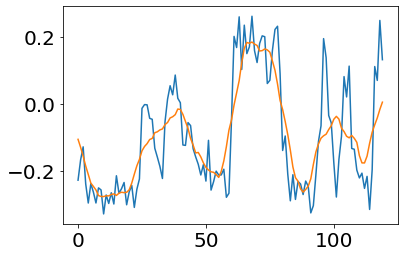

In [46]:
plt.plot(lt_lb[0,:])
N = 10
plt.plot(np.convolve(lt_lb[0,:], np.ones(N)/N, mode='same'))

In [54]:
# low res neural WITH SMOOTHING

N = 3

neural_L = []
for i in range(lt_lb.shape[0]):
    a = np.convolve(lt_lb[i,:], np.ones(N)/N, mode='same')
    b = np.convolve(lt_rb[i,:], np.ones(N)/N, mode='same')
    neural_L.append(a-b)
neural_L = np.asarray(neural_L)

neural_R = []
for i in range(rt_lb.shape[0]):
    a = np.convolve(rt_lb[i,:], np.ones(N)/N, mode='same')
    b = np.convolve(rt_rb[i,:], np.ones(N)/N, mode='same')
    neural_R.append(a-b)
neural_R = np.asarray(neural_R)

neural_low_res = {'L': neural_L, 'R': neural_R}

In [40]:
# low res neural
neural_L = lt_lb-lt_rb
neural_R = rt_lb-rt_rb

# re-zscore for avg trace plot
neural_L/=np.std(neural_L)
neural_R/=np.std(neural_R)

neural_low_res = {'L': neural_L, 'R': neural_R}
neural_low_res['L'].shape, neural_low_res['R'].shape

((1362, 120), (2424, 120))

In [16]:
# high res behavior
beh_high_res = {'L': beh_traces_L_stacked,
                'R': beh_traces_R_stacked,
                'LF': beh_traces_L_F_stacked,
                'RF': beh_traces_R_F_stacked,
                'LA': beh_traces_L_A_stacked,
                'RA': beh_traces_R_A_stacked}

beh_high_res['L'].shape, beh_high_res['R'].shape

((1362, 3000), (2424, 3000))

In [17]:
# # first lets try finding bouts with no behavior before
# start = 800
# stop = 1450
# beh_threshs = [5000,10000,20000,40000,10000000000]

# bouts_filtered = {'L': [], 'R': []}
# for beh in ['L', 'R']:
#     pre_beh_amount = np.sum(np.abs(beh_high_res[beh])[:,start:stop],axis=1)
#     for beh_thresh in beh_threshs:
#         bouts_filtered[beh].append(np.where(pre_beh_amount<beh_thresh)[0])

In [22]:
# first lets try finding bouts with no behavior before
start = 800
stop = 1450
#beh_threshs = [5000,10000,20000,40000,10000000000]

bouts_filtered = {'L': [], 'R': []}
for beh in ['L', 'R']:
    pre_beh_amount = np.sum(np.abs(beh_high_res[beh])[:,start:stop],axis=1)
    ind = np.argsort(pre_beh_amount)
    bouts_filtered[beh] = ind
    #for beh_thresh in beh_threshs:
    #    bouts_filtered[beh].append(np.where(pre_beh_amount<beh_thresh)[0])

In [111]:
xs[800]

-13.98

In [18]:
# ### NEW - filter based on rot and fwd
# # first lets try finding bouts with no behavior before
# start = 800
# stop = 1450

# bouts_filtered = {'L': [], 'R': []}
# for beh in ['L', 'R']:
# #     pre_beh_amount_rot = np.sum(np.abs(beh_high_res[beh])[:,start:stop],axis=1)
# #     pre_beh_amount_fwd = np.sum(np.abs(beh_high_res[beh+'F'])[:,start:stop],axis=1)
# #     pre_beh_amount = pre_beh_amount_rot+pre_beh_amount_fwd*5
# #     ind = np.argsort(pre_beh_amount)
# #     bouts_filtered[beh] = ind
#     pre_beh_amount = np.sum(np.abs(beh_high_res[beh+'A'])[:,start:stop],axis=1)
#     ind = np.argsort(pre_beh_amount)
#     bouts_filtered[beh] = ind

In [21]:
bouts_filtered['L'][:30]

array([ 404,  352,  400,  409,  411,  402,  274,  315,  263,  269,  264,
        348,  321,  336,  270,  395,  410, 1282,  343,  683,  271,  362,
        266,  375,  449,  398,  365,  401,  366,  625])

In [17]:
#[0,4,6,7,8]

num_bouts_L = []
num_bouts_R = []
for i in range(len(peaks_all_fly)):
    num_bouts_L.append(len(peaks_all_fly[i]['L']))
    num_bouts_R.append(len(peaks_all_fly[i]['R']))
num_bouts_L = np.cumsum(num_bouts_L)
num_bouts_R = np.cumsum(num_bouts_R)

nbL = np.insert(num_bouts_L,0,0)
nbR = np.insert(num_bouts_R,0,0)

for fly in range(len(peaks_all_fly)):
    print(nbL[fly+1]-nbL[fly], nbR[fly+1]-nbR[fly])

222 519
38 33
140 2
47 105
178 291
27 543
364 601
276 219
70 111


In [18]:
import random

In [21]:
bouts_filtered[beh][thresh]

404

In [63]:
xs = np.arange(0,532*60,532)+(532/2) #change to 60 if changed above
xs

array([  266.,   798.,  1330.,  1862.,  2394.,  2926.,  3458.,  3990.,
        4522.,  5054.,  5586.,  6118.,  6650.,  7182.,  7714.,  8246.,
        8778.,  9310.,  9842., 10374., 10906., 11438., 11970., 12502.,
       13034., 13566., 14098., 14630., 15162., 15694., 16226., 16758.,
       17290., 17822., 18354., 18886., 19418., 19950., 20482., 21014.,
       21546., 22078., 22610., 23142., 23674., 24206., 24738., 25270.,
       25802., 26334., 26866., 27398., 27930., 28462., 28994., 29526.,
       30058., 30590., 31122., 31654.])

In [34]:
xs[1500]

0.0

In [33]:
xs = np.arange(0,30000,20) #change to 60 if changed above
xs = np.concatenate((xs[::-1]*-1, xs))/1000

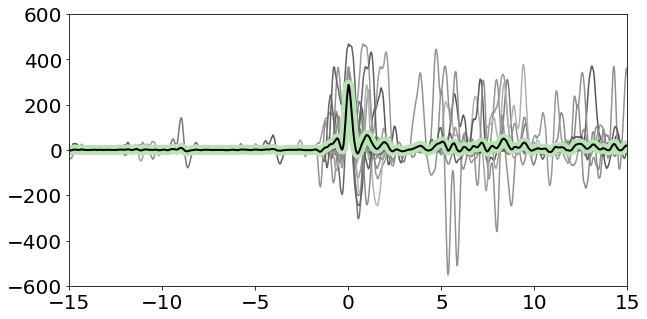

In [59]:
beh = 'L'
#colors = {'R': '#BB4141', 'L':'#0AA71D'}
thresh = 0

plt.figure(figsize=(10,5))
bouts = bouts_filtered[beh][:18]
for bout in bouts:
    c = random.uniform(.3, .7)
    plt.plot(xs, beh_high_res[beh][bout,:],color=(c,c,c))
trace = np.mean(beh_high_res[beh][bouts,:],axis=0)
plt.plot(xs, trace, color = colors[beh][thresh], lw=10)
plt.plot(xs, trace, color = 'k', lw=2)
plt.ylim(-600,600)
plt.xlim(-15,15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=False)

In [77]:
beh_high_res['L'].shape, beh_high_res['R'].shape

((1362, 3000), (2424, 3000))

In [39]:
beh_high_res['RF'].shape

(1362, 3000)

In [46]:
beh = 'R'
beh + 'F'

'RF'

(-10, 20)

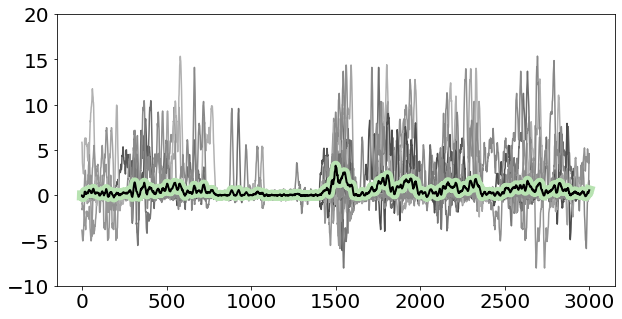

In [61]:
beh = 'L'
#colors = {'R': '#BB4141', 'L':'#0AA71D'}
thresh = 0

plt.figure(figsize=(10,5))
bouts = bouts_filtered[beh][:18]
beh = beh + 'F'
for bout in bouts:
    c = random.uniform(.3, .7)
    plt.plot(beh_high_res[beh][bout,:],color=(c,c,c))
trace = np.mean(beh_high_res[beh][bouts,:],axis=0)

beh = beh[0]
plt.plot(trace, color = colors[beh][thresh], lw=10)
plt.plot(trace, color = 'k', lw=2)
plt.ylim(-10,20)

In [20]:
import matplotlib

percentials = [2,5,10,50,100]

colors = {}
cmap = matplotlib.cm.get_cmap('Greens')
colors['L'] = cmap(np.linspace(.3,1,len(percentials)))
cmap = matplotlib.cm.get_cmap('Reds')
colors['R'] = cmap(np.linspace(.3,1,len(percentials)))

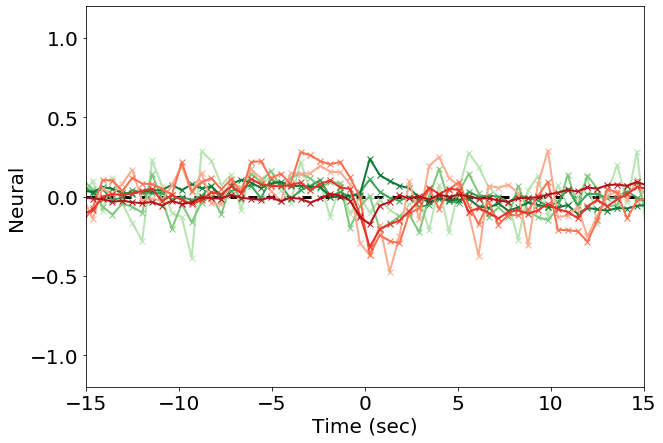

In [21]:
plt.figure(figsize=(10,7))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)

for beh in ['L','R']:
    for k,num_bout in enumerate([27,100,500,10000]):#[70,2000]):#[30,100,500,1000]):
        #num_bout = int(percential*len(bouts_filtered[beh])/100)
        plt.plot(low_res_xs/1000, np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],:],axis=0),
                 color=colors[beh][k],lw=2,label=num_bout,marker='x')
#plt.legend()
#plt.ylim(-.14,.14)
plt.ylim(-1.2,1.2)
plt.xlim(-15,15)
plt.xlabel('Time (sec)')
plt.ylabel('Neural')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [41]:
len(np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],:],axis=0))

120

In [127]:
low_res_xs[31], low_res_xs[45], low_res_xs[54]

(-15162.0, -7714.0, -2926.0)

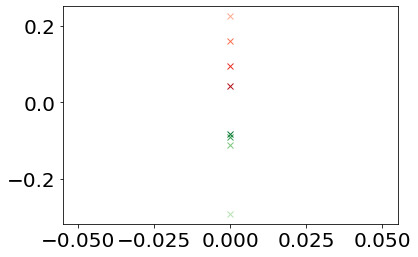

In [128]:
for beh in ['L','R']:
    for k,num_bout in enumerate([27,100,500,10000]):#[70,2000]):#[30,100,500,1000]):
        #num_bout = int(percential*len(bouts_filtered[beh])/100)
        plt.plot([0], np.mean(np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],:],axis=0)[31:54]),
                 color=colors[beh][k],lw=2,label=num_bout,marker='x')

In [31]:
random.seed(0)
a = np.random.randint(0,1000,49)
print(a)
print('\n')
print(a[36],a[37])

[649 759  23 569 427 522 812 615 632 674  15 521 821 336 563  10 637 144
 561 979 115 583 476 338 957 628 112  90 147 457 845 248 220 492 216 814
 459 601 519 439 229 985 609 650 681 240 414 429 445]


459 601


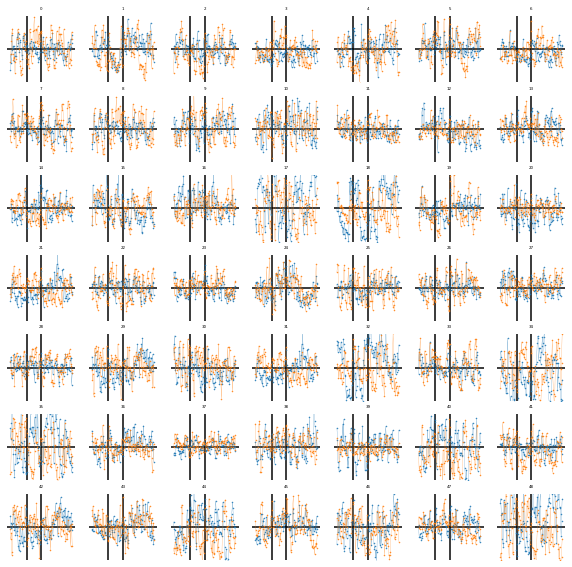

In [20]:
random.seed(0)

plt.figure(figsize=(10,10))
beh = 'R'
bn = 5

for k,bn in enumerate(np.random.randint(0,1000,49)):
    plt.subplot(7,7,k+1)
    
    plt.axhline(0,color='k')
    plt.axvline(0,color='k')
    plt.axvline(-15,color='k')
    
    a = rt_lb[bouts_filtered[beh][bn],:]
    b = rt_rb[bouts_filtered[beh][bn],:]
    plt.plot(low_res_xs/1000, a,label='Left Brain',marker='o',ms=.5,lw=.2)
    plt.plot(low_res_xs/1000, b,label='Right Brain',marker='o',ms=.5,lw=.2)
    #plt.legend()
    #plt.title('Right turns')
    #plt.ylabel('neural activity')
    #plt.xlabel('time, s')
    plt.axis('off')

    plt.ylim(-.3,.3)
    plt.title(k,fontsize=4)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=600,bbox_inches='tight',transparent=False)

In [ ]:
1

In [151]:
low_res_xs[59], low_res_xs[61]

(-266.0, 798.0)

In [85]:
low_res_xs[32], low_res_xs[45], low_res_xs[57], len(low_res_xs), neural_low_res[beh].shape

(-14630.0, -7714.0, -1330.0, 120, (1362, 120))

In [22]:
num_bout = 30

start = 32
stop = 57

# start = 59
# stop = 61
accuracy = []
for num_bout in range(0,1300):
    beh = 'R'
    R = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],start:stop],axis=1)
    beh = 'L'
    L = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],start:stop],axis=1)
    #R.shape, L.shape

    thresh = 0
    num_correct = np.sum(L<thresh) + np.sum(R>thresh)
    accuracy.append(num_correct/(num_bout*2))

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
start = 32
stop = 57
beh = 'R'
R = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],start:stop],axis=1)

start = 32
stop = 57
beh = 'L'
L = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],start:stop],axis=1)

In [76]:
start = 32
stop = 57
beh = 'R'
#R_baseline = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],:start],axis=1)
R = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],start:stop],axis=1)
#R -= R_baseline

start = 32
stop = 57
beh = 'L'
#L_baseline = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],:start],axis=1)
L = np.mean(neural_low_res[beh][bouts_filtered[beh][:27],start:stop],axis=1)
#L -= L_baseline

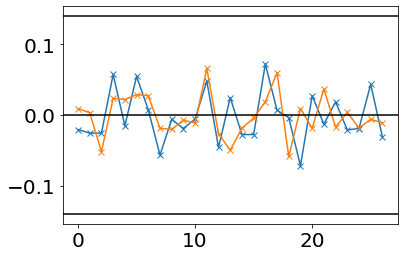

In [77]:
plt.plot(R,marker='x')
plt.plot(L,marker='x')
plt.axhline(0,color='k')
plt.axhline(0.14,color='k')
plt.axhline(-0.14,color='k')
#left is orange, needs to be high

In [78]:
thresh = 0
np.sum(L>thresh)/len(L), np.sum(R<-thresh)/len(R), np.mean([np.sum(L>thresh)/len(L), np.sum(R<-thresh)/len(R)])

(0.4444444444444444, 0.6296296296296297, 0.537037037037037)

In [26]:
np.sum(np.abs(R)<0.005), np.sum(np.abs(L)<0.005)

(5, 3)

In [33]:
#basically, if very near 0, just label it as chance.
L[np.where(np.abs(L)<0.005)]

array([0.00107885, 0.00429167, 0.00107885])

In [30]:
L

array([ 0.01336128,  0.04514697, -0.04178054,  0.04262   ,  0.02429263,
       -0.00993563,  0.01236215, -0.03072443,  0.01688649,  0.00870443,
        0.01513387,  0.01075861, -0.01849907, -0.02082707,  0.00107885,
       -0.01145431,  0.04117518,  0.06583557, -0.02023133,  0.00429167,
        0.00107885,  0.02325961,  0.01394822, -0.02285918, -0.01295664,
        0.00522293,  0.00566327])

In [27]:
thresh = 0.005
np.sum(L>thresh)/len(L), np.sum(R<-thresh)/len(R), np.mean([np.sum(L>thresh)/len(L), np.sum(R<-thresh)/len(R)])

(0.5555555555555556, 0.5185185185185185, 0.537037037037037)

In [ ]:
#for left is 13 samples, right is 15 samples

In [133]:
np.mean(R), np.mean(L)

(-0.0248454545028874, -0.022311517347443403)

In [ ]:
# 18 above for L, only 8 below
# 9 above for R, 17 below

In [ ]:

num_correct = np.sum(L<thresh) + np.sum(R>thresh)
accuracy.append(num_correct/(num_bout*2))

In [ ]:
# left for LH will likely be >0

In [63]:
accuracy

[nan,
 0.5,
 0.25,
 0.3333333333333333,
 0.375,
 0.3,
 0.4166666666666667,
 0.35714285714285715,
 0.375,
 0.3333333333333333,
 0.3,
 0.2727272727272727,
 0.2916666666666667,
 0.3076923076923077,
 0.35714285714285715,
 0.3333333333333333,
 0.34375,
 0.35294117647058826,
 0.3333333333333333,
 0.34210526315789475,
 0.325,
 0.3333333333333333,
 0.3181818181818182,
 0.32608695652173914,
 0.3333333333333333,
 0.36,
 0.36538461538461536,
 0.35185185185185186,
 0.375,
 0.3793103448275862,
 0.38333333333333336,
 0.3870967741935484,
 0.390625,
 0.3787878787878788,
 0.36764705882352944,
 0.35714285714285715,
 0.375,
 0.3783783783783784,
 0.3815789473684211,
 0.38461538461538464,
 0.375,
 0.3780487804878049,
 0.36904761904761907,
 0.36046511627906974,
 0.36363636363636365,
 0.37777777777777777,
 0.3804347826086957,
 0.3829787234042553,
 0.3854166666666667,
 0.37755102040816324,
 0.38,
 0.39215686274509803,
 0.3942307692307692,
 0.4056603773584906,
 0.4166666666666667,
 0.41818181818181815,
 0.4285

In [20]:
from random import choices

In [41]:
bouts_filtered['L'].shape

()

In [39]:
xs[800], xs[1100]

(-13.98, -7.98)

In [42]:
#################
### Bootstrap ### special version with optional thresh padding (and separate predictions for L/R)
################# (and option baseline subtraction)

num_bout = 'all'
t='0'
thresh = 0#0.005#0.06
accuracy = {}
for num_bout in [27, 'all']:
    for t in ['0', 'early']:

        if t == '0':
            start = 59
            stop = 61
        elif t == 'early':
            start = 32
            stop = 57

        acc = []
        for iteration in range(10000):

            if num_bout == 'all':
                n_bout = 1000#3786
                bt_L = choices(range(1362), k=n_bout)#1362)
                bt_R = choices(range(2424), k=n_bout)#2424)
            
            if num_bout == 27:
                n = num_bout
                n_bout = num_bout
                bt_L = choices(range(n), k=n)
                bt_R = choices(range(n), k=n)

            r_bouts = neural_low_res['R'][bouts_filtered['R'][bt_R]]
            l_bouts = neural_low_res['L'][bouts_filtered['L'][bt_L]]
            
            ### optional baseline subtraction
            #r_baseline = np.mean(r_bouts[:,:32],axis=1)
            #l_baseline = np.mean(l_bouts[:,:32],axis=1)
            
            r = r_bouts[:,start:stop]#-r_baseline[:,np.newaxis]
            l = l_bouts[:,start:stop]#-l_baseline[:,np.newaxis]
            R = np.mean(r,axis=1)
            L = np.mean(l,axis=1)
            
            ###new: predicting based on early behavior
            #R = np.mean(beh_high_res['R'][bt_R,800:1100],axis=1)
            #L = np.mean(beh_high_res['L'][bt_L,800:1100],axis=1)

            ### direction correct for IPS
#             if t == '0':
#                 acc.append(np.mean([np.sum(L>thresh)/n_bout, np.sum(R<-thresh)/n_bout]))
#             elif t == 'early':
#                 acc.append(np.mean([np.sum(L<thresh)/n_bout, np.sum(R>-thresh)/n_bout]))
            
            ### direction correct for LH
            if t == '0':
                acc.append(np.mean([np.sum(L>thresh)/n_bout, np.sum(R<-thresh)/n_bout]))
            elif t == 'early':
                acc.append(np.mean([np.sum(L>thresh)/n_bout, np.sum(R<-thresh)/n_bout]))
        accuracy[F'{num_bout}{t}'] = acc

In [ ]:
*p < 0.05, **p < 0.01,
***p 0.001

In [30]:
# #################
# ### Bootstrap ###
# #################

# num_bout = 'all'
# t='0'
# thresh = 0
# accuracy = {}
# for num_bout in [27, 'all']:
#     for t in ['0', 'early']:

#         if t == '0':
#             start = 59
#             stop = 61
#         elif t == 'early':
#             start = 32
#             stop = 57

#         acc = []
#         for iteration in range(1000):

#             if num_bout == 'all':
#                 n_bout = 1000#3786
#                 bt_L = choices(range(1362), k=n_bout)#1362)
#                 bt_R = choices(range(2424), k=n_bout)#2424)
#                 n_bout *= 2
#             n = 27#18
#             if num_bout == 27:
#                 n_bout = n*2
#                 bt_L = choices(range(n), k=n)
#                 bt_R = choices(range(n), k=n)

#             r_bouts = neural_low_res['R'][bouts_filtered['R'][bt_R]]
#             l_bouts = neural_low_res['L'][bouts_filtered['L'][bt_L]]
                
#             r_very_early = np.mean(r_bouts[:,20:25],axis=1)
#             l_very_early = np.mean(l_bouts[:,20:25],axis=1)
            
#             r = r_bouts[:,start:stop]#+r_very_early[:,np.newaxis]
#             l = l_bouts[:,start:stop]#+l_very_early[:,np.newaxis]
#             R = np.mean(r,axis=1)
#             L = np.mean(l,axis=1)
            
#             ###new: predicting based on early behavior
#             #R = np.mean(beh_high_res['R'][bt_R,800:1100],axis=1)
#             #L = np.mean(beh_high_res['L'][bt_L,800:1100],axis=1)

#             ### direction correct for IPS
# #             if t == '0':
# #                 acc.append((np.sum(R<thresh) + np.sum(L>thresh))/n_bout)
# #             elif t == 'early':
# #                 acc.append((np.sum(R>thresh) + np.sum(L<thresh))/n_bout)
            
#             ### direction correct for LH
#             if t == '0':
#                 acc.append((np.sum(R<thresh) + np.sum(L>thresh))/n_bout)
#             elif t == 'early':
#                 acc.append((np.sum(R<thresh) + np.sum(L>thresh))/n_bout)
#         accuracy[F'{num_bout}{t}'] = acc

In [107]:
np.mean(accuracy['27early'])

0.5018518518518519

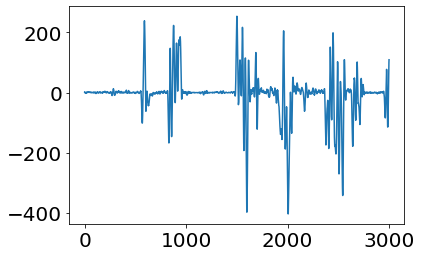

In [86]:
plt.plot(beh_high_res['L'][0,:])

In [89]:
beh_high_res['R'].shape

(1741, 3000)

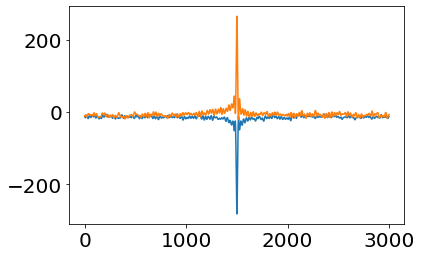

In [91]:
plt.plot(np.mean(beh_high_res['R'],axis=0))
plt.plot(np.mean(beh_high_res['L'],axis=0))

In [94]:
np.mean(R), np.mean(L)

(-14.005357768109365, -7.349906189514957)

(array([ 12.,  27.,  44., 116., 239., 462., 460., 272.,  86.,  23.]),
 array([-157.21931903, -132.61538908, -108.01145914,  -83.40752919,
         -58.80359924,  -34.19966929,   -9.59573935,   15.0081906 ,
          39.61212055,   64.2160505 ,   88.81998044]),
 <a list of 10 Patch objects>)

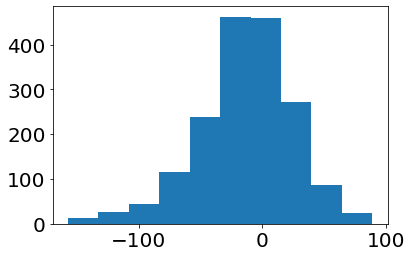

In [88]:
plt.hist(R)

(array([  4.,  12.,  34.,  65., 120., 277., 320., 186.,  78.,  14.]),
 array([-148.83381347, -125.19615725, -101.55850104,  -77.92084483,
         -54.28318861,  -30.6455324 ,   -7.00787618,   16.62978003,
          40.26743625,   63.90509246,   87.54274868]),
 <a list of 10 Patch objects>)

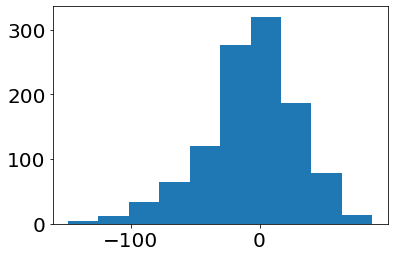

In [92]:
plt.hist(L)

In [99]:
R = np.mean(beh_high_res['R'][:,:800],axis=1)
np.sum(R>0)
# so there are 1741 right bouts, and 626 early are above

567

In [82]:
626/1741

0.3595634692705342

In [80]:
beh_high_res['L'].shape

(1110, 3000)

In [100]:
L = np.mean(beh_high_res['L'][:,:800],axis=1)
np.sum(L<0)
# so there are 1110 left bouts, and 492 early are above

664

In [83]:
492/1110

0.44324324324324327

In [67]:
R = np.mean(beh_high_res['R'][:,800:1100],axis=1)
L = np.mean(beh_high_res['L'][:,800:1100],axis=1)

(np.sum(R>thresh) + np.sum(L<thresh))/3786
#print(np.sum(early_beh<0))
#print(2424/2)

0.37717908082408874

In [101]:
1-(567+664)/(1741+1110)

0.5682216766047001

In [97]:
1-(626+618)/(1741+1110)

0.563661873027008

In [ ]:
early_beh<0

In [64]:
early_beh = np.mean(beh_high_res['L'][:,800:1100],axis=1)
print(np.sum(early_beh<0))
print(2424/2)

716
1212.0


In [47]:
n_bout = 1000#3786
bt_L = choices(range(1362), k=n_bout)#1362)

In [48]:
.shape

(1000,)

In [44]:
beh_high_res['L'].shape

(1362, 3000)

In [107]:
scipy.stats.ttest_1samp(accuracy['allearly'], popmean=0.5)

Ttest_1sampResult(statistic=-18.680916059674008, pvalue=5.022042020263382e-67)

In [113]:
scipy.stats.ttest_1samp(accuracy['allearly'], popmean=0.5)

Ttest_1sampResult(statistic=-117.811439335864, pvalue=0.0)

(array([2.000e+00, 2.300e+01, 1.590e+02, 8.610e+02, 2.358e+03, 3.255e+03,
        2.342e+03, 8.280e+02, 1.610e+02, 1.100e+01]),
 array([0.587 , 0.5959, 0.6048, 0.6137, 0.6226, 0.6315, 0.6404, 0.6493,
        0.6582, 0.6671, 0.676 ]),
 <a list of 10 Patch objects>)

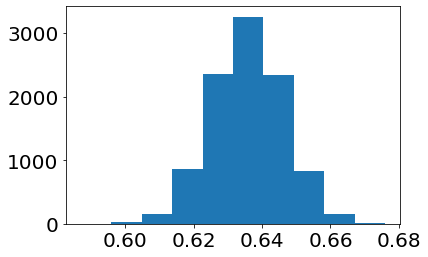

In [34]:
# all_0


plt.hist(accuracy['all0'])

In [37]:
.5778*(.1)*2

0.11556

In [35]:
np.std(accuracy['all0'])

0.010551099562486375

In [57]:
np.sum(np.asarray(accuracy['allearly'])<.50)/10000

0.7277

In [54]:
np.mean(accuracy['allearly'])

0.49292935

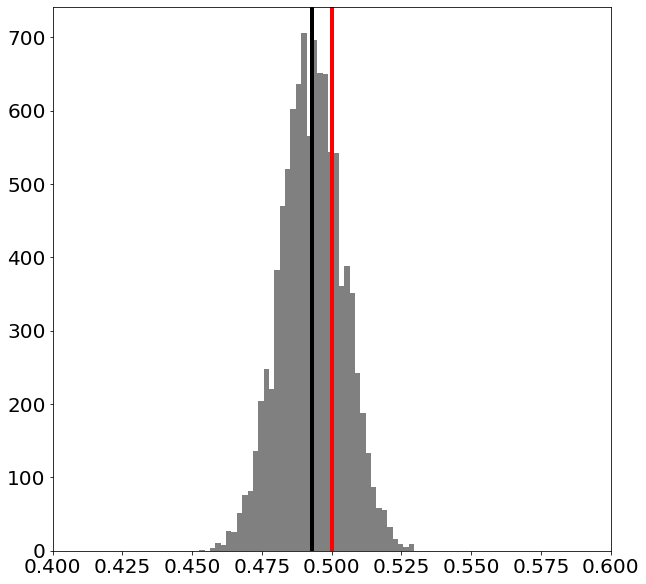

In [47]:
plt.figure(figsize=(10,10))
plt.hist(accuracy['allearly'],bins=40,color='grey')
plt.axvline(.5,color='r',lw=4)
plt.axvline(0.4929,color='k',lw=4)
plt.xlim(.4,.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [53]:
np.sum(np.asarray(accuracy['allearly'])>0.5)/10000

0.2588

In [48]:
pval = sum(s >= s0)/N;

NameError: name 's' is not defined

In [43]:
0/10000

0.0

0.49 0.7277
0.66 0.0
0.54 0.2527
0.74 0.0


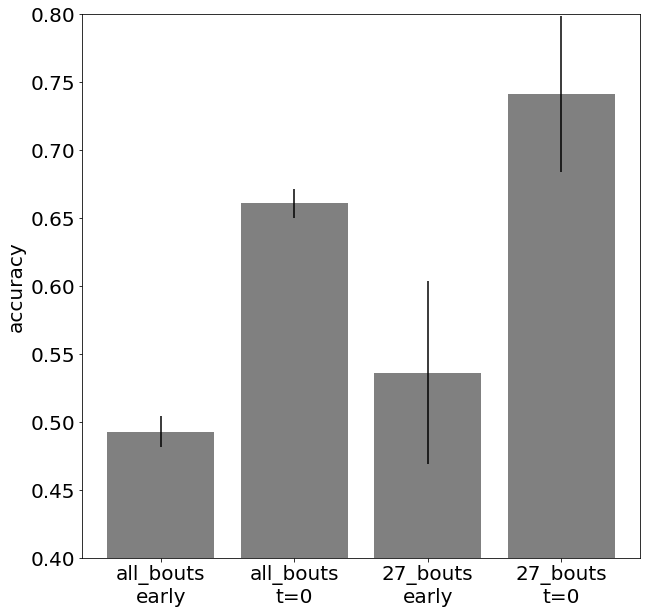

In [43]:
plt.figure(figsize=(10,10))

for k,id_ in enumerate(['allearly', 'all0', '27early', '270']):
    pvalue = np.sum(np.asarray(accuracy[id_])<.50)/10000 #num bootstraps
    print('{:.02f} {}'.format(np.mean(accuracy[id_]),pvalue))
    plt.bar([k],np.mean(accuracy[id_]),yerr=np.std(accuracy[id_]),color='grey')
plt.ylim(.4,.8)
plt.ylabel('accuracy')
plt.xticks([0,1,2,3],['all_bouts\nearly','all_bouts\nt=0','27_bouts\nearly','27_bouts\nt=0'])

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# update to match new behavior prediction method

In [ ]:
# so the key is i need to do each fly independently

In [43]:
#################
### Bootstrap ###
#################

num_bout = 'all'
t='0'
thresh = 0
accuracy = {}

for num_bout in [27, 'all']:
    for t in ['0', 'early']:

        if t == '0':
            start = 59
            stop = 61
        elif t == 'early':
            start = 32
            stop = 57

        fly_acc = []
        for fly in range(9):
            acc = []
            for iteration in range(100):

                if num_bout == 'all':
                    n_bout = 1000#3786
                    bt_L = choices(range(nbL[fly],nbL[fly+1]), k=n_bout)#1362)
                    bt_R = choices(range(nbR[fly],nbR[fly+1]), k=n_bout)#2424)
                    n_bout *= 2
                n = 27#18
                if num_bout == 27:
                    n_bout = n*2
                    bt_L = choices(range(n), k=n)
                    bt_R = choices(range(n), k=n)

                r_bouts = neural_low_res['R'][bouts_filtered['R'][bt_R]]
                l_bouts = neural_low_res['L'][bouts_filtered['L'][bt_L]]

                r = r_bouts[:,start:stop]
                l = l_bouts[:,start:stop]
                R = np.mean(r,axis=1)
                L = np.mean(l,axis=1)

                if t == '0':
                    acc.append((np.sum(R<thresh) + np.sum(L>thresh))/n_bout)
                elif t == 'early':
                    acc.append((np.sum(R>thresh) + np.sum(L<thresh))/n_bout)
            fly_acc.append(np.asarray(acc))
        accuracy[F'{num_bout}{t}'] = np.asarray(fly_acc)

In [46]:
len(accuracy['allearly'])

9

In [47]:
accuracy['allearly'].shape

(9, 100)

In [44]:
np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]]

array([0.51761 , 0.526775, 0.49685 , 0.45041 , 0.421005])

In [53]:
np.mean(np.mean(accuracy['all0'],axis=1)[[0,4,6,7,8]])

0.648443

In [30]:
np.average(np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]],weights=[222+519, 178+291, 364+601, 276+219, 70+111])

0.5433786811645037

In [50]:
.5779*(.5-.482)*10#*2*np.sqrt(5)

0.10402200000000009

In [52]:
np.std(np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]])*2*np.sqrt(5)

0.18122150920903404

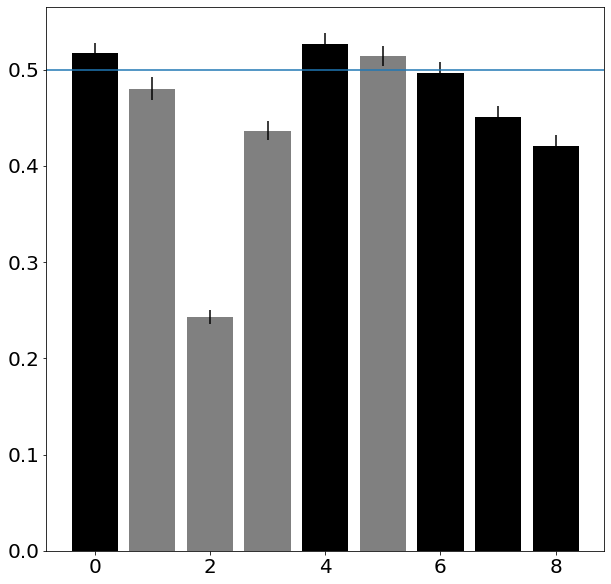

In [46]:
plt.figure(figsize=(10,10))

for k in range(9):
    if k in [0,4,6,7,8]:
        color='k'
    else:
        color='grey'
    plt.bar([k],np.mean(accuracy['allearly'],axis=1)[k],yerr=np.std(accuracy['allearly'],axis=1)[k],color=color)
#plt.ylim(.4,.8)
#plt.ylabel('accuracy')
#plt.xticks([0,1,2,3],['all_bouts\nearly','all_bouts\nt=0','27_bouts\nearly','27_bouts\nt=0'])

plt.axhline(0.5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [37]:
.5761*.22*2/np.sqrt(5)

0.11336149104171132

In [36]:
np.std(np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]])

0.022672565800985166

In [47]:
scipy.stats.ttest_1samp(np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]], popmean=0.5)

Ttest_1sampResult(statistic=-0.8622399788506765, pvalue=0.4371816622573333)

In [50]:
np.average(np.mean(accuracy['allearly'],axis=1)[[0,4,6,7,8]],weights=[222+519, 178+291, 364+601, 276+219, 70+111])

0.5396888512802525

# cluster

In [117]:
r_bouts = neural_low_res['R'][bouts_filtered['R'][:27]]
l_bouts = neural_low_res['L'][bouts_filtered['L'][:27]]

In [119]:
l_bouts.shape

(27, 120)

clustering.........
complete!
0.027278661727905273


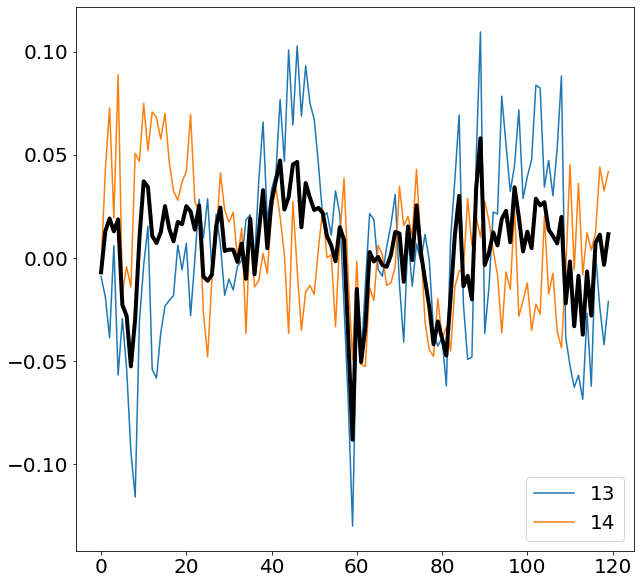

In [122]:
to_cluster = r_bouts

m = np.mean(to_cluster[:,:55],axis=1)
s = np.std(to_cluster[:,:55],axis=1)
to_cluster = (to_cluster-m[:,np.newaxis])/s[:,np.newaxis]

n_clusters = 2
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster[:,:55])
print('complete!')
print(time.time()-t0)

plt.figure(figsize=(10,10))
cluster_means = []
for label in np.unique(model.labels_):
    ids = np.where(model.labels_==label)[0]
    cluster_means.append(np.mean(r_bouts[ids,:],axis=0))
    plt.plot(cluster_means[label],label=len(ids))

plt.plot(np.mean(r_bouts,axis=0),color='k',lw=4)
plt.legend()

# logistic regression

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [116]:
X = np.concatenate((neural_low_res['L'][:,:55], neural_low_res['R'][:,:55]),axis=0)
print(X.shape)

y = np.hstack((np.zeros(neural_low_res['L'].shape[0]),np.ones(neural_low_res['R'].shape[0])))
#np.random.shuffle(y)
print(y.shape)

clf = LogisticRegression(random_state=0).fit(X, y)
clf.score(X, y)

(3786, 55)
(3786,)


0.6452720549392499

In [105]:
clf.intercept_

array([0.6571291])

In [113]:
neural_low_res['L'].shape

(1362, 120)

In [146]:
os.listdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_087/func_0/fictrac/')

['fictrac_2d_hist_fixed.png',
 'fictrac-20200228_161226.log',
 'fictrac-20200228_161226-raw.avi',
 'fictrac.xml',
 'velocity_trace.png',
 'fictrac-20200228_161226.dat',
 'fictrac-20200228_161226-debug.avi',
 'fictrac_2d_hist.png']

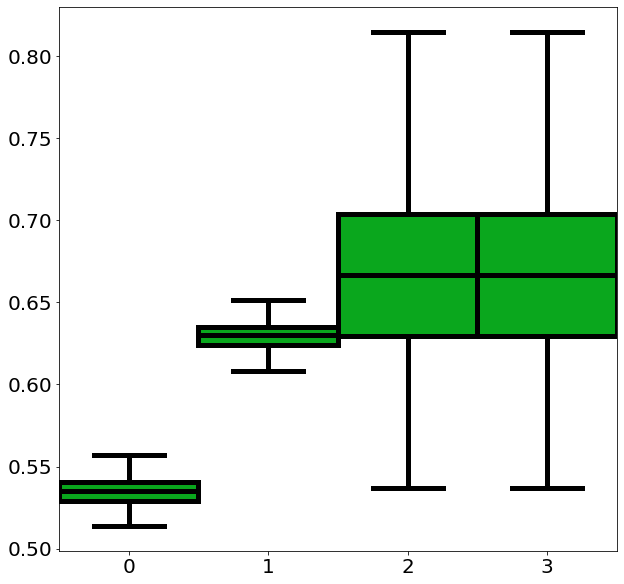

In [134]:
plt.figure(figsize=(10,10))
ax = plt.gca()

for k,id_ in enumerate(['allearly', 'all0', '27early', '270']):
    bplot = ax.boxplot(accuracy[id_],positions=[k],showfliers=False,widths=1,notch=False,patch_artist=True,
               medianprops={"linewidth": 5,"solid_capstyle": "butt","color":'k'},
               boxprops={"linewidth": 5,"color":'k'},
               capprops={"linewidth": 5,"color":'k'},
               whiskerprops={"linewidth": 5,"color":'k'})
    bplot['boxes'][0].set_facecolor('#0AA71D')

In [108]:
2424+1362

3786

In [117]:
L.shape

(1362,)

In [69]:
#72% for top 100 regions at t=0

In [89]:
accuracy[27]

0.6666666666666666

In [50]:
at_early = accuracy.copy()

In [221]:
at_0 = accuracy.copy()

Text(0.5, 1.0, 'zoom')

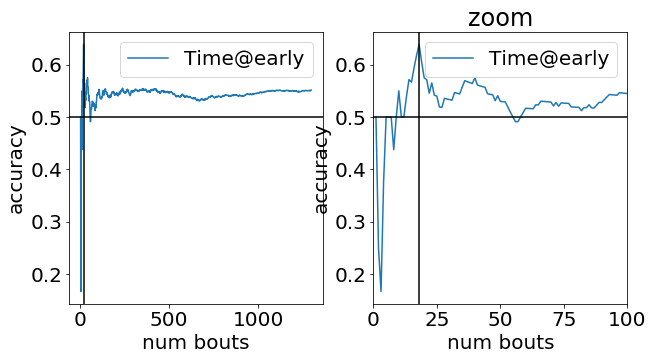

In [53]:
plt.figure(figsize=(10,5))

for i in [0,1]:
    plt.subplot(1,2,i+1)
    #plt.plot(at_0,label='Time@0')
    plt.plot(at_early,label='Time@early')

    plt.axhline(.5,color='k')
    plt.axvline(18,color='k')
    plt.xlabel('num bouts')
    plt.ylabel('accuracy')
    plt.legend()
plt.xlim(0,100)
plt.title('zoom')

Text(0.5, 1.0, 'zoom')

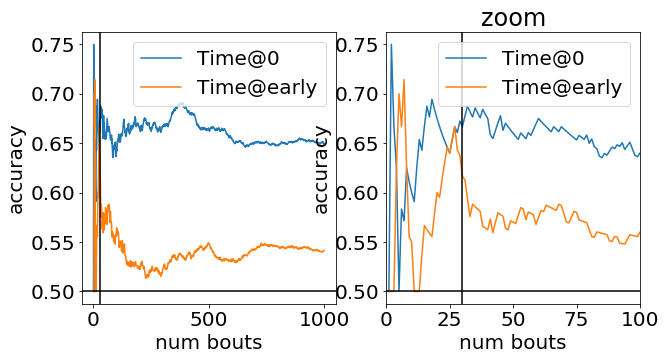

In [226]:
plt.figure(figsize=(10,5))

for i in [0,1]:
    plt.subplot(1,2,i+1)
    plt.plot(at_0,label='Time@0')
    plt.plot(at_early,label='Time@early')

    plt.axhline(.5,color='k')
    plt.axvline(30,color='k')
    plt.xlabel('num bouts')
    plt.ylabel('accuracy')
    plt.legend()
plt.xlim(0,100)
plt.title('zoom')

Text(0.5, 1.0, 'behavior -15to-2')

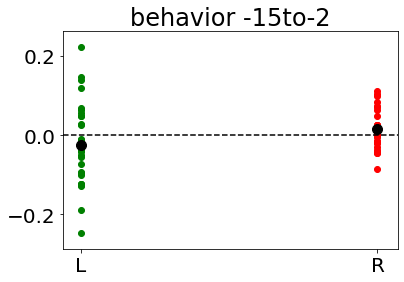

In [189]:
plt.axhline(0,linestyle='--',color='k')
plt.scatter([0]*num_bout,L,color='green')
plt.scatter([0],np.mean(L),color='k',s=100)
plt.scatter([1]*num_bout,R,color='red')
plt.scatter([1],np.mean(R),color='k',s=100)
plt.xticks([0,1],['L','R'])
plt.title('behavior -15to-2')

In [175]:
thresh = 0
num_correct = np.sum(L<thresh) + np.sum(R>thresh)
num_correct/(num_bout*2)

0.3333333333333333

In [176]:
thresh = 0
num_correct = np.sum(L>thresh) + np.sum(R<thresh)
num_correct/(num_bout*2)

0.6666666666666666

In [159]:
bouts_filtered['L'].shape, bouts_filtered['R'].shape

((1362,), (2424,))

In [74]:
Ls = []
Rs = []
for num_bout in range(1000):
    beh = 'R'
    R = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],32:57])
    Rs.append(R)
    beh = 'L'
    L = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],32:57])
    Ls.append(L)

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


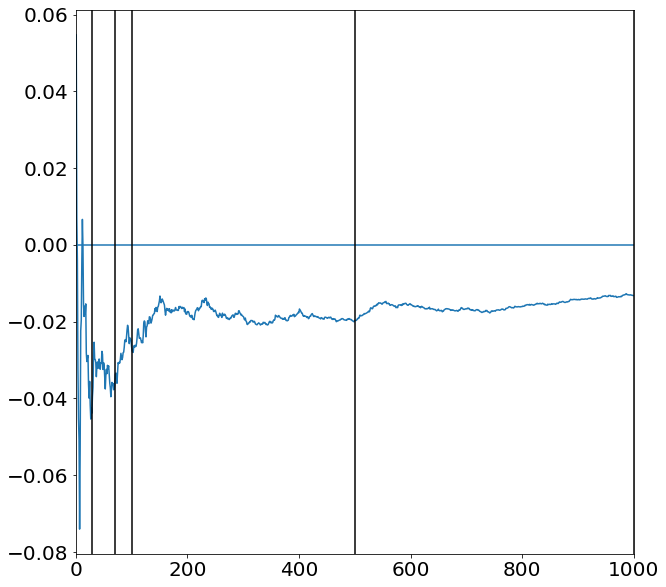

In [77]:
plt.figure(figsize=(10,10))
plt.plot(np.asarray(Ls)-np.asarray(Rs))
#plt.plot(Rs)
plt.xlim(0,1000)
plt.axhline(0)
for line in [30,70,100,500,1000]:
    plt.axvline(line,color='k')

TypeError: object of type 'numpy.int64' has no len()

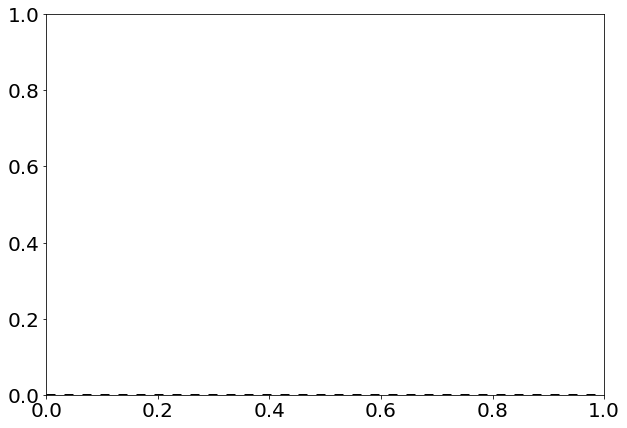

In [84]:
plt.figure(figsize=(10,7))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)

for beh in ['L','R']:
    for bt in range(len(beh_threshs)):
        plt.plot(low_res_xs/1000, np.mean(neural_low_res[beh][bouts_filtered[beh][bt],:],axis=0),
                 color=colors[beh][bt],lw=2,label=len(bouts_filtered[beh][bt]))
plt.legend()
plt.ylim(-.14,.14)
plt.xlabel('Time (sec)')
plt.ylabel('Neural')

Text(0, 0.5, 'Neural')

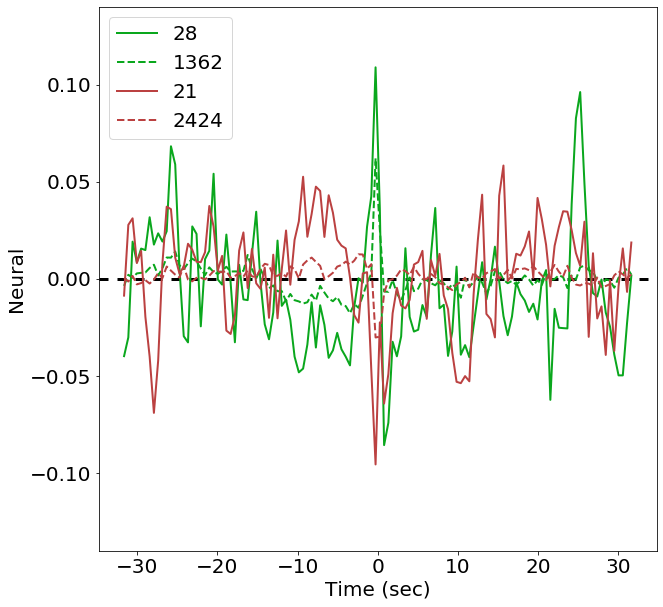

In [117]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)

for beh in ['L','R']:
    for bt in [0,4]:#range(len(beh_threshs)):
        if bt == 0:
            ls = '-'
        else:
            ls = '--'
        plt.plot(low_res_xs/1000, np.mean(neural_low_res[beh][bouts_filtered[beh][bt],:],axis=0),
                 color=colors[beh],lw=2,linestyle=ls,label=len(bouts_filtered[beh][bt]))
plt.legend()
plt.ylim(-.14,.14)
plt.xlabel('Time (sec)')
plt.ylabel('Neural')

In [11]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

behavior_super = {}
behavior_super['Y_pos_std'] = beh_fwd
behavior_super['Z_pos_std'] = np.clip(beh_turn,0,None)
behavior_super['Z_neg_std'] = np.clip(beh_turn,None,0)*-1

(30456,)
(30456,)


In [12]:
supercluster_signals.shape

(30456, 501)

In [18]:
clusters = [57,77,185,186]
clusters_c = [i+250 for i in clusters]

In [19]:
neu = np.mean(supercluster_signals[:,clusters],axis=1) - np.mean(supercluster_signals[:,clusters_c],axis=1)
neu.shape

(30456,)

In [20]:
r,p = scipy.stats.pearsonr(neu,behavior_super['Z_pos_std'])
print(r,p)

0.13882182590608624 6.767938812304825e-131


In [21]:
r,p = scipy.stats.pearsonr(neu,behavior_super['Z_neg_std'])
print(r,p)

-0.14059450685848043 3.0495097008166543e-134
